In [2]:
# ============================================================
# Notebook setup
# ============================================================

# Retrain or use existing models
use_cached_weights=True

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

import numpy as np
from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

<center>
<img src="assets/trm04.png" width=75%>
    <big><strong>03. Off-beat Path
        </strong></big>
</center>

## Two-Stage Stochastic Optimization

**Let's consider this variant of our example problem**

$$
z^*(u) = \text{argmin} \left\{ \mathbb{E}_{y \sim P(Y \mid X =x)} \left[ \sum_{j=1}^n \sin(2\pi u_j z_j) \right] \mid v^T z \geq r, z \in [0, 1]^n \right\}
$$

It's similar to the one-stage variant, except that:

* The decision variables are continuous
* The cost function is non-linear
* We using $u$ to denote the uncertain parameters

> It's just another one-stage stochastic optimization problem,<bR>**but the use of $\sin$ terms makes it much more challenging**

## SFGE Enables Objective Decoupling

**We will see that it can _also_ be addressed via DFL**

The point is that the SFGE approach has a nice property:

* The function $g(\hat{y}, y)$ used as a loss term
* ...And the cost we use to compute $z^*(y)$

...Can be _completely distinct_

**We can put this to our advantage**

* In particular, we can use an ML model
* ...To _guide a low-complexity problem_
* ...So that we get a solution for tougher one

...And since we are using DFL we also get a contextual approach (we react to $x$)

## Target Problem

**Let's try to come up with a formalization**

Say we want to target an optimization problem in the form:

$$
\text{argmin}_z\ \left\{ \mathbb{E}_{u \sim P(Y \mid X=x)} \left[ f(z, u, x) \right] \mid z \in F(x) \right\}
$$

Where:

* $x$ is an observable, $z$ is a vector of decisions
* $u$ is a vector of parameters
* $f(z, u, x)$ is the cost function (which can depend on the observable)
* $F(x)$ is the feasible space (which can depend on the observable)
* A training sample $\{(x_i, u_i)\}_{i=1}^m$ from the distribution $P(X, U)$

**This is a (slightly) generalized version of the problem class targeted by DFL**

## A DFL Approach

**In principle we can apply "normal" DFL to this problem**

First, we define:

$$
z^*(u, x) = \text{argmin}_{z} \{ f(z, u, x) \mid z \in F(x) \}
$$

Then, at training time we solve:

$$
\theta^* = \text{argmin}_\theta\ \left\{ \mathbb{E}_{(x, u) \sim P(X, U)} \left[ f(z^*(\hat{u}, x), u, x) - f(z^*(u, x), u, x)  \right] \mid \hat{y} = h(x, \theta) \right\}
$$

**In practice, if $f(z, u, x)$ is not linear like in our current example**

...Then doing it would _not be easy at all_

* We'd need to use a non-linear solver
* ...And the computational cost would be much higher

## Another DFL Approach 

**But we can cheat! Since SFGE enables distinct costs**

...We can compute $z^*$ through a _surrogate problem_:

$$
z^*(y, x) = \text{argmin}_{z} \{ \tilde{f}(z, y, x) \mid z \in \tilde{F}(y, x) \}
$$

* $z$ is the same decision vector as before
* ...But $y$ is a set of created ad-hoc for the surrogate
* We'll call them _virtual parameters_, because they may have real counterpart

Then:

* $\tilde{f}(z, y, x)$ is a surrogate cost function
* $\tilde{F}(y, x)$ is a surrogate feasible space

For the solution to be valid we need to have $z \in \tilde{F}(y, x) \Rightarrow z \in F(x)$

## Another DFL Approach 

**At training time, we solve:**

$$
\theta^* = \text{argmin}_\theta\ \left\{ \mathbb{E}_{(x, u) \sim P(X, U)} \left[ f(z^*(y, x), u, x)  \right] \mid y = h(x, \theta) \right\}
$$

Intuitively:

* We observe $x$ and we estimate a virtual parameter vector $y$
* We obtain a decision vector $z^*(y, x)$ through the surrogate problem
* Then we evaluate the cost via the true cost function $f(z, u)$

**There is a distinction between the virtual parameter $y$ for $z^*(y, x)$**

...And the parameters $u$ for $f(z, u, x)$ are distinct

* For this reason, there is no ground truth for $y$
* ...Which prevents us from using a regret loss

## Motivation

**The appeal here is that the surrogate problem can be _easier to solve_**

In our example, instead of using:

$$
z^*(u, x) = \text{argmin} \left\{ \sum_{j=1}^n \sin(2\pi u_j z_j) \mid v^T z \geq r, z \in [0, 1]^n \right\}
$$

We could use instead the following surrogate:

$$
z^*(y, x) = \text{argmin} \left\{ y^T z \mid v^T z \geq r, z \in [0, 1]^n \right\}
$$

**The surrogate is an LP, so it's very fast to solve**

* Together with the ML estimator, it can still lead to high-quality solutions
* As long as the surrogate is _sufficiently well aligned_ with the true problem

## Benchmark Data

**Let's try a proof-of-concept experiment**

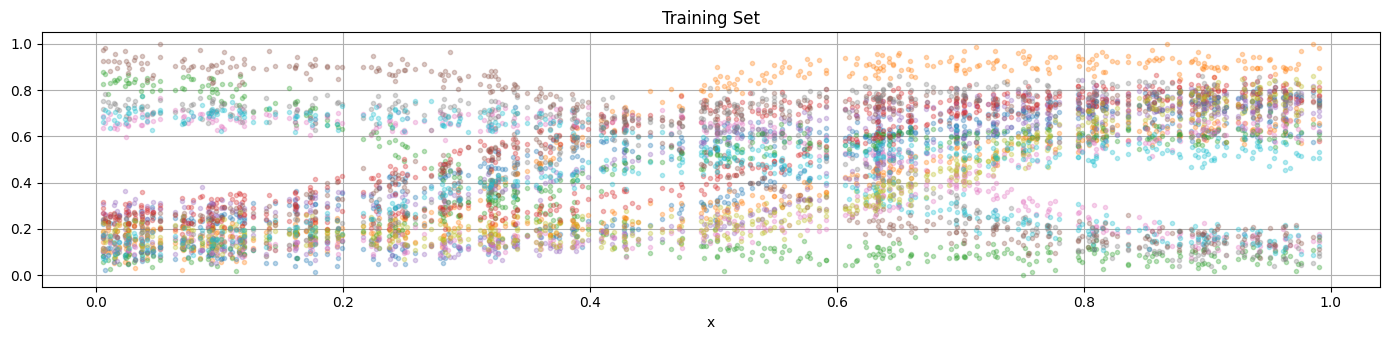

In [3]:
seed, nitems = 42, 20
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=.1, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)

* We generate data for the $u$ parameter as in all previous variants
* We keep the distribution simple, since we want to stress non-linearity

## Benchmark Data

**Then we generate the remaining problem data and a test set**

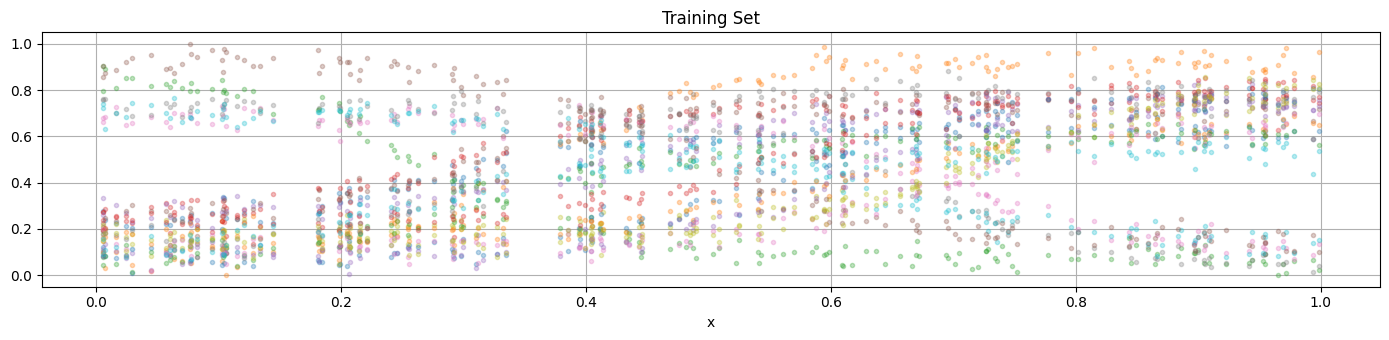

In [4]:
rel_req = 0.6
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed, surrogate=True)
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0.1, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_ts, figsize=figsize, title='Training Set', scatter=True)

## A Baseline

**We'll use again a PFL approach as a baseline**

Note this is _not a particularly good choice_, but it's difficult to find an alternative

CPU times: user 8.61 s, sys: 256 ms, total: 8.87 s
Wall time: 7.16 s


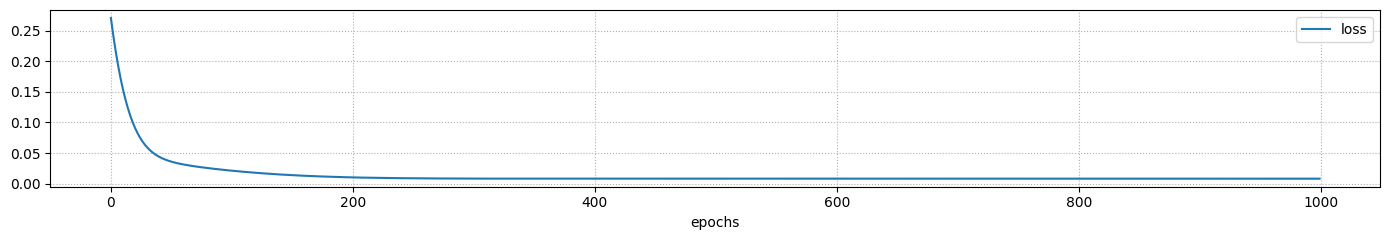

R2: 0.84, MAE: 0.076, RMSE: 0.09 (training)
R2: 0.84, MAE: 0.079, RMSE: 0.09 (training)


In [5]:
pfl_nl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='pfl_nl', output_activation='linear')
%time history = util.train_nn_model(pfl_nl, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(pfl_nl, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_nl, data_ts.index.values, data_ts.values, label='training')

## PFL Approach Evaluation

**We'll also evaluate the results in terms of cost, not relative regret**

Again, the reason is that this problem is not so easy to solve

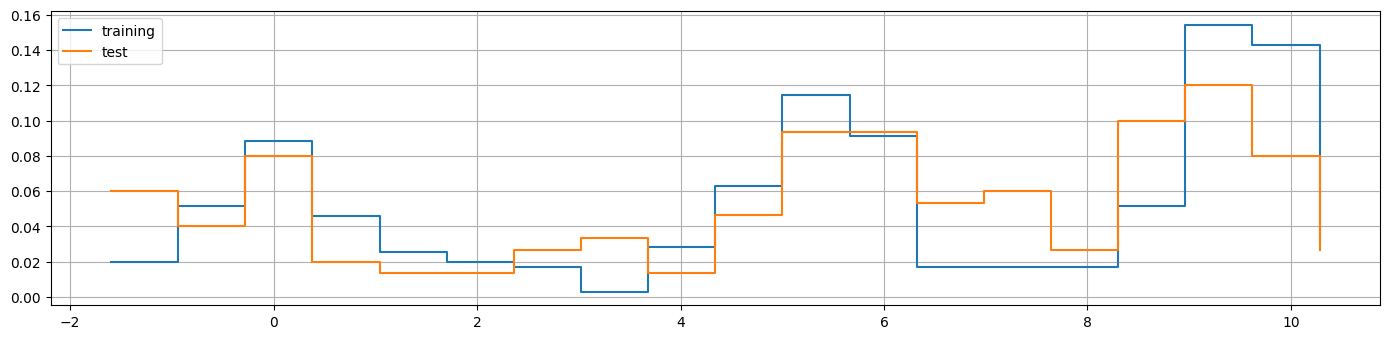

Mean: 5.691 (training), 5.497 (test)


In [6]:
tc_tr_nl = util.compute_regret_surrogate(prb, pfl_nl, data_tr, tlim=10, cost_only=True)
tc_ts_nl = util.compute_regret_surrogate(prb, pfl_nl, data_ts, tlim=10, cost_only=True)
util.plot_histogram(tc_tr_nl, figsize=figsize, label='training', data2=tc_ts_nl, label2='test', print_mean=True)

## Alternative DFL Approach

**We can now try out alternative DFL approach**

In this case, warm starting may not be a good idea

CPU times: user 3min 35s, sys: 3.43 s, total: 3min 38s
Wall time: 3min 38s


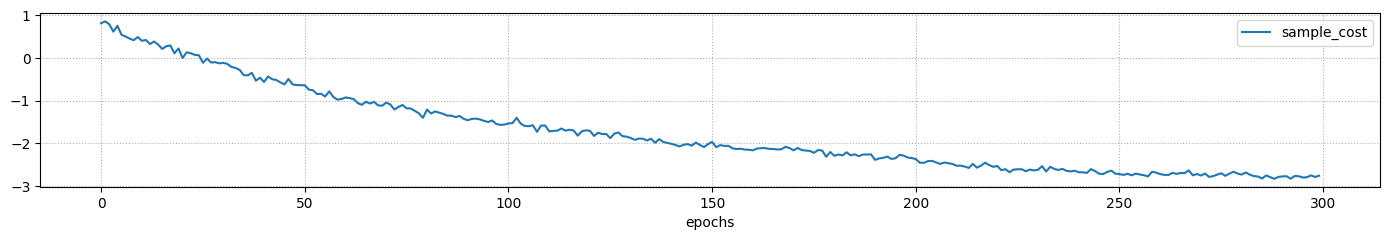

R2: -6.83, MAE: 0.5, RMSE: 0.61 (training)
R2: -6.54, MAE: 0.5, RMSE: 0.61 (test)


In [7]:
sfge_sg = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='sfge_sg', output_activation='linear', loss_type='cost', sfge=True, sfge_sigma_init=0.10, sfge_sigma_trainable=True, standardize_loss=True, surrogate=True)
%time history = util.train_dfl_model(sfge_sg, data_tr.index.values, data_tr.values, epochs=300, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False, excluded_metrics=['sigma', 'loss'])
util.print_ml_metrics(sfge_sg, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(sfge_sg, data_ts.index.values, data_ts.values, label='test')

## DFL Approach Evaluation

**...And we can compare the two cost distributions on the training data**

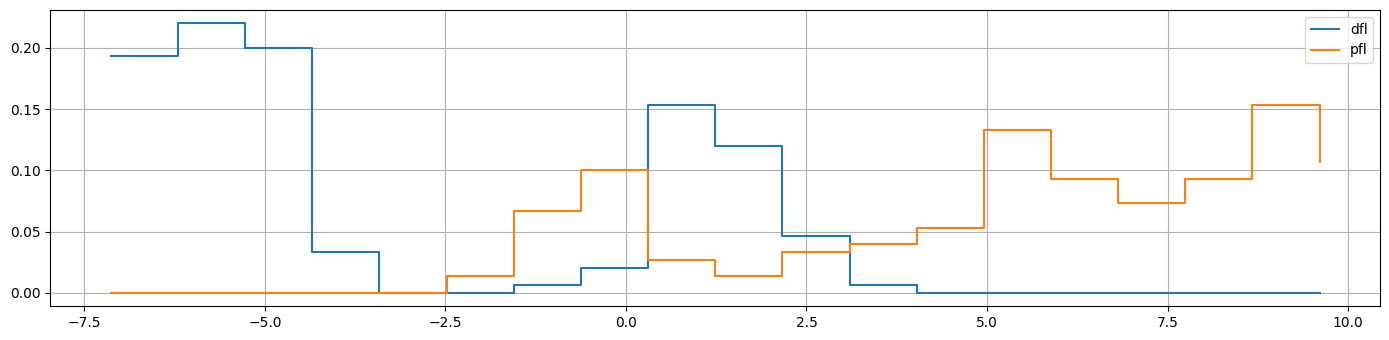

Mean: -3.178 (dfl), 5.497 (pfl)


In [8]:
tc_tr_sg = util.compute_regret_surrogate(prb, sfge_sg, data_tr, tlim=10, cost_only=True)
tc_ts_sg = util.compute_regret_surrogate(prb, sfge_sg, data_ts, tlim=10, cost_only=True)
util.plot_histogram(tc_ts_sg, figsize=figsize, label='dfl', data2=tc_ts_nl, label2='pfl', print_mean=True)

The difference is very noticeable

## Considerations

**By using DFL + a surrogate we can "partition" the problem complexity**

* We can simplify some elements that the solver has trouble addressing
* ...And dump them partially on the ML model
* ...Or we can do the opposite (e.g. hard constraints in ML based decision making)
* It can work without an observable (no $x$)
* It could be used for black-box optimization

**Some caveats:**

* This is not a well investigate approach: treat is as a proof-of-concept
* Banning special case, the method works as a heuristic
* ...And finding a good surrogate can be quite difficult